In [1]:
import numpy as np
import xarray as xr
import math
import matplotlib.pyplot as plt
from scipy import stats
from numpy import matlib
import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.path as mpath
import matplotlib.ticker as mticker 
from matplotlib import mlab
from scipy import integrate

# Read the monthly O3 

### Ozone forcing HIST

In [2]:
%cd /sfs/fs1/work-geomar/smomw418/models/foci/experiments
hist_o3 = xr.open_dataset('FOCI1.14-SW079_echam6_echam_1850-2099_ao3_pl.nc', decode_times=True)
hist_o3 = hist_o3.sel(time=slice('1958-01-01', '2013-12-31'))

/sfs/fs1/work-geomar/smomw418/models/foci/experiments


### FOCI-MOZ

In [3]:
%cd sw054
sw054_o3 = xr.open_dataset('FOCI1.4-SW054_echam6_alltrm_1954-2013_O3_pl.nc', decode_times=True)
sw054_o3 = sw054_o3.sel(time=slice('1958-01-01', '2013-12-31'))
%cd sw064
sw064_o3 = xr.open_dataset('FOCI1.4-SW064_echam6_alltrm_1952-2013_O3_pl.nc', decode_times=True)
sw064_o3 = sw064_o3.sel(time=slice('1958-01-01', '2013-12-31'))
%cd sw065
sw065_o3 = xr.open_dataset('FOCI1.4-SW065_echam6_alltrm_1950-2013_O3_pl.nc', decode_times=True)
sw065_o3 = sw065_o3.sel(time=slice('1958-01-01', '2013-12-31'))

(bookmark:sw054) -> /sfs/fs1/work-geomar/smomw418/models/foci/experiments/FOCI1.4-SW054/outdata/echam6
/sfs/fs1/work-geomar/smomw418/models/foci/experiments/FOCI1.4-SW054/outdata/echam6
(bookmark:sw064) -> /sfs/fs1/work-geomar/smomw418/models/foci/experiments/FOCI1.4-SW064/outdata/echam6
/sfs/fs1/work-geomar/smomw418/models/foci/experiments/FOCI1.4-SW064/outdata/echam6
(bookmark:sw065) -> /sfs/fs1/work-geomar/smomw418/models/foci/experiments/FOCI1.4-SW065/outdata/echam6
/sfs/fs1/work-geomar/smomw418/models/foci/experiments/FOCI1.4-SW065/outdata/echam6


In [4]:
# Make sure all have the same lat
sw064_o3 = sw064_o3.assign_coords(lat=sw054_o3.lat)
sw065_o3 = sw065_o3.assign_coords(lat=sw054_o3.lat)
hist_o3 = hist_o3.assign_coords(lat=sw054_o3.lat)

## Define function to compute volume mixing ratio (ppmv)

In [5]:
def vmr(ozone):
    # Input: ozone -> O3 mass mixing ratio in kg/kg

    # Convert from kg/kg to microg/g (multiply by 10^6)
    m = ozone*1e6
    # Convert the mass mixing ratio to volume mixing ratio in ppmv
    vmr = m*(28.9644/47.9982) # approx 0.603
    
    return vmr

## Compute volume mixing ratio (in ppmv)

In [6]:
sw054_o3

<xarray.Dataset>
Dimensions:  (lat: 96, lon: 192, plev: 26, time: 672)
Coordinates:
  * lon      (lon) float32 0.0 1.875 3.75 5.625 ... 352.5 354.375 356.25 358.125
  * lat      (lat) float32 88.57217 86.722534 84.86197 ... -86.722534 -88.57217
  * plev     (plev) float64 1e+05 9.25e+04 8.5e+04 7.75e+04 ... 50.0 20.0 10.0
  * time     (time) datetime64[ns] 1958-01-31T23:52:00 ... 2013-12-31T23:52:00
Data variables:
    O3       (time, plev, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.0 (http://mpimet.mpg.de/...
    Conventions:  CF-1.6
    history:      Wed Mar 07 08:43:05 2018: cdo -t /gfs2/work/shkifmsw/models...
    CDO:          Climate Data Operators version 1.9.0 (http://mpimet.mpg.de/...

In [7]:
sw054_vmr = vmr(sw054_o3.O3)
sw064_vmr = vmr(sw064_o3.O3)
sw065_vmr = vmr(sw065_o3.O3)

hist_vmr = vmr(hist_o3.ao3)

## Compute ensemble means

In [8]:
sw065_vmr = sw065_vmr.rename({'lev': 'plev'})

In [9]:
moz_vmr = xr.concat((sw054_vmr, sw064_vmr, sw065_vmr), dim='exp').mean(dim='exp')

/sfs/fs6/home-geomar/smomw418/miniconda3/envs/py3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


## Compute difference in monthly O3 

In [10]:
def ii_sel_months(data):
    #----------------------------------------select each calendar month and average over it for each year----------------------------------
    # Input: data = xarray containing the data
    # Output: an array with yearly timeseries for each month
    # Author: Ioana Ivanciu (27.10.2018)
    #------------------------------------------------------------------------------------------------------------------------------
    
    import xarray as xr
    
    # Define boolean masks for each month
    def is_jan(month):
        return month==1 # returns an array with true where the month is in Jan and false elswhere
    def is_feb(month):
        return month==2
    def is_mar(month):
        return month==3
    def is_apr(month):
        return month==4
    def is_may(month):
        return month==5
    def is_jun(month):
        return month==6
    def is_jul(month):
        return month==7
    def is_aug(month):
        return month==8
    def is_sep(month):
        return month==9
    def is_oct(month):
        return month==10
    def is_nov(month):
        return month==11
    def is_dec(month):
        return month==12
    
    
    # Select each mon and average it over each year
    data_jan = data.sel(time=is_jan(data['time.month'])).groupby('time.year').mean(dim='time')
    data_feb = data.sel(time=is_feb(data['time.month'])).groupby('time.year').mean(dim='time')
    data_mar = data.sel(time=is_mar(data['time.month'])).groupby('time.year').mean(dim='time')
    data_apr = data.sel(time=is_apr(data['time.month'])).groupby('time.year').mean(dim='time')
    data_may = data.sel(time=is_may(data['time.month'])).groupby('time.year').mean(dim='time')
    data_jun = data.sel(time=is_jun(data['time.month'])).groupby('time.year').mean(dim='time')
    data_jul = data.sel(time=is_jul(data['time.month'])).groupby('time.year').mean(dim='time')
    data_aug = data.sel(time=is_aug(data['time.month'])).groupby('time.year').mean(dim='time')
    data_sep = data.sel(time=is_sep(data['time.month'])).groupby('time.year').mean(dim='time')
    data_oct = data.sel(time=is_oct(data['time.month'])).groupby('time.year').mean(dim='time')
    data_nov = data.sel(time=is_nov(data['time.month'])).groupby('time.year').mean(dim='time')
    data_dec = data.sel(time=is_dec(data['time.month'])).groupby('time.year').mean(dim='time')
    
    data_mon = xr.concat([data_jan, data_feb, data_mar, data_apr, data_may, data_jun, data_jul, data_aug, data_sep, data_oct, data_nov, data_dec], 'month')
    
    return data_mon

In [11]:
def ii_ens31_mon_diff_zonal_anom(data1, data2, data3, ens1, lev):
    #---------------------------------------Difference of means and its significance------------------------------------
    # Input: data1, data2 -> xarray data arrays with dimensions time, plev, lon, lat (lon must be present!)
    # Output: 
    
    # Select pressure level
    data1 = data1.sel(plev=lev)
    data2 = data2.sel(plev=lev)
    data3 = data3.sel(plev=lev)
    ens1 = ens1.sel(plev=lev)
    
    # Select months
    dmon1 = ii_sel_months(data1)
    dmon2 = ii_sel_months(data3)
    dmon3 = ii_sel_months(data3)
    emon1 = ii_sel_months(ens1)
     
    # Compute the ensemble mean 
    ens_mean1 = xr.concat((dmon1, dmon2, dmon3), dim='exp').mean(dim='exp')
    ens_mean2 = emon1

    # Compute the variance over the stacked ensemble members for each season
    stack1 = xr.concat((dmon1, dmon2, dmon3), dim='year') # stack the ensemble members over dimension time
    
    var1 = ((stack1 - stack1.mean(dim='year'))**2).sum(dim='year') # compute the variance
    var2 = ((emon1 - emon1.mean(dim='year'))**2).sum(dim='year') # compute the variance    
   
    # Define function for t-test (95%) 
    
    def ii_t_test(data1, data2, var1, var2):
        #------------------ t-test for the significance of the difference of means-----------------------------------
        # Following Zwiers and von Storch (1995) and von Storhc and Zwiers Statistical Analysis in Climate Reasearch book.
        # The test is appropriete when the sum of the effective sample sizes of the two samples is grater than 30 (assuming equal varience).
        # Assumptions: 
        #     - the process from which "observations" are sampled is a Gaussian red noise process (AR(1))
        #     - both samples for which the difference of mean is tested come from red noise processes with equal variance and equal lag-1 autocorrelation
        # Input : data1, data2 -> the two 3D arrays for which the difference in means and its significance is calculated
        # Output: mean1., mean2 -> 2D arrays of time means corresponfing to data1, and data2, respectively
        #         diff -> the difference of means (2D array)
        #         signif -> 2D array with 1 where diff is significant at the 95% level and 0 elsewhere
        #         t -> the test statistic (difference divioded by its standard error); (2D array)
        #         cv -> the critical value for the respective DOF and signif level (95%, two-sided test); (2D array)
        #         df -> the correspondig degress of freedom, given by the sum of the effective sample sizes -2; (2D array)
        # Author: Ioana Ivanciu on 28.03.2019

        import scipy.stats as st
        
        # Compute the pooled sample variance (Zwiers and von Storch 1995 eq. 13/ von Storch and Zwiers eq. 6.17)
        mean1 = data1.mean(dim='year')
        mean2 = data2.mean(dim='year')
        var = (var1 + var2) / ( len(data1.year)*3+len(data2.year)-2 )
    
        # Degrees of freedom for the t-test
        df = len(data1.year)*3+len(data2.year)-2  # von Storch and Zwiers book section 6 pg. 121
    
        # Compute the test statistic (von Storch and Zwiers book section 6 pg. 121 eq. 6.23; this differes from 
        # Zwiers and von Storch 1995 eq. 12 as the square root is placed elsewhere 
        diff = mean1 - mean2
        t = diff / ( np.sqrt(var) * np.sqrt(1/(len(data1.year)*3) + 1/len(data2.year) ))
    
        # Compute the critical value for a two-sided t-test with df
        # Use scipy.stats.t.pff -> gives the point at which a given percentile occurs for the t-distribution with df
        cv = st.t.ppf(0.975,df) # 0.975 because we want a two-sided test
    
        # Construct array with 1 where the difference is significant and 0 elsewhere
        signif = np.zeros(t.shape)
        signif[(xr.ufuncs.fabs(t)>cv).values] = 1 # take absolute value of t to include negative values
    
        return mean1, mean2, diff, signif, t, cv, df
    
    # Compute means, the difference between means and the significance
    mean1, mean2, diff, _, t, cv, _ = ii_t_test(ens_mean1, ens_mean2, var1, var2)
    
    sign = xr.where(xr.ufuncs.fabs(t)>cv, diff, np.nan)
    
    return mean1, mean2, diff, sign

In [12]:
moz_mean_vmr, hist_mean_vmr, diff_vmr, sign_vmr = ii_ens31_mon_diff_zonal_anom(sw054_vmr, sw064_vmr, sw065_vmr, hist_vmr, 7000)

## Read the temperature and U

### FOCI-HIST

In [13]:
%cd -b sw060
sw060 = xr.open_dataset('FOCI1.7-SW060_echam6_ATM_mm_1958-2013.nc', decode_times=True)
%cd -b sw061
sw061 = xr.open_dataset('FOCI1.7-SW061_echam6_ATM_mm_1958-2013.nc', decode_times=True)
%cd -b jh019
jh019 = xr.open_dataset('FOCI1.9.4-JH019_echam6_ATM_mm_1958-2013.nc', decode_times=True)

(bookmark:sw060) -> /sfs/fs1/work-geomar/smomw418/models/foci/experiments/FOCI1.7-SW060/outdata/echam6
/sfs/fs1/work-geomar/smomw418/models/foci/experiments/FOCI1.7-SW060/outdata/echam6
(bookmark:sw061) -> /sfs/fs1/work-geomar/smomw418/models/foci/experiments/FOCI1.7-SW061/outdata/echam6
/sfs/fs1/work-geomar/smomw418/models/foci/experiments/FOCI1.7-SW061/outdata/echam6
(bookmark:jh019) -> /sfs/fs1/work-geomar/smomw418/models/foci/experiments/FOCI1.9.4-JH019/outdata/echam6
/sfs/fs1/work-geomar/smomw418/models/foci/experiments/FOCI1.9.4-JH019/outdata/echam6


### FOCI-MOZ

In [14]:
%cd -b sw054
sw054 = xr.open_dataset('FOCI1.4-SW054_echam6_ATM_mm_full.nc', decode_times=True)
%cd -b sw064
sw064 = xr.open_dataset('FOCI1.4-SW064_echam6_ATM_mm_full.nc', decode_times=True)
%cd -b sw065
sw065 = xr.open_dataset('FOCI1.4-SW065_echam6_ATM_mm_full.nc', decode_times=True)

(bookmark:sw054) -> /sfs/fs1/work-geomar/smomw418/models/foci/experiments/FOCI1.4-SW054/outdata/echam6
/sfs/fs1/work-geomar/smomw418/models/foci/experiments/FOCI1.4-SW054/outdata/echam6
(bookmark:sw064) -> /sfs/fs1/work-geomar/smomw418/models/foci/experiments/FOCI1.4-SW064/outdata/echam6
/sfs/fs1/work-geomar/smomw418/models/foci/experiments/FOCI1.4-SW064/outdata/echam6
(bookmark:sw065) -> /sfs/fs1/work-geomar/smomw418/models/foci/experiments/FOCI1.4-SW065/outdata/echam6
/sfs/fs1/work-geomar/smomw418/models/foci/experiments/FOCI1.4-SW065/outdata/echam6


In [15]:
def ii_ens3_mon_diff_zonal_anom(data1, data2, data3, ens1, ens2, ens3, lev):
    #---------------------------------------Difference of means and its significance------------------------------------
    # Input: data1, data2 -> xarray data arrays with dimensions time, plev, lon, lat (lon must be present!)
    # Output: 

    # Select pressure level
    data1 = data1.sel(plev=lev)
    data2 = data2.sel(plev=lev)
    data3 = data3.sel(plev=lev)
    ens1 = ens1.sel(plev=lev)
    ens2 = ens2.sel(plev=lev)
    ens3 = ens3.sel(plev=lev)
   
    # Select months
    dmon1 = ii_sel_months(data1)
    dmon2 = ii_sel_months(data3)
    dmon3 = ii_sel_months(data3)
    emon1 = ii_sel_months(ens1)
    emon2 = ii_sel_months(ens2)
    emon3 = ii_sel_months(ens3)
     
    # Compute the ensemble mean 
    ens_mean1 = xr.concat((dmon1, dmon2, dmon3), dim='exp').mean(dim='exp')
    ens_mean2 = xr.concat((emon1, emon2, emon3), dim='exp').mean(dim='exp')

    # Compute the variance over the stacked ensemble members for each season
    stack1 = xr.concat((dmon1, dmon2, dmon3), dim='year') # stack the ensemble members over dimension time
    stack2 = xr.concat((emon1, emon2, emon3), dim='year') # stack the ensemble members over dimension time
    
    var1 = ((stack1 - stack1.mean(dim='year'))**2).sum(dim='year') # compute the variance
    var2 = ((stack2 - stack2.mean(dim='year'))**2).sum(dim='year') # compute the variance  
   
    # Define function for t-test (95%) 
    
    def ii_t_test(data1, data2, var1, var2):
        #------------------ t-test for the significance of the difference of means-----------------------------------
        # Following Zwiers and von Storch (1995) and von Storhc and Zwiers Statistical Analysis in Climate Reasearch book.
        # The test is appropriete when the sum of the effective sample sizes of the two samples is grater than 30 (assuming equal varience).
        # Assumptions: 
        #     - the process from which "observations" are sampled is a Gaussian red noise process (AR(1))
        #     - both samples for which the difference of mean is tested come from red noise processes with equal variance and equal lag-1 autocorrelation
        # Input : data1, data2 -> the two 3D arrays for which the difference in means and its significance is calculated
        # Output: mean1., mean2 -> 2D arrays of time means corresponfing to data1, and data2, respectively
        #         diff -> the difference of means (2D array)
        #         signif -> 2D array with 1 where diff is significant at the 95% level and 0 elsewhere
        #         t -> the test statistic (difference divioded by its standard error); (2D array)
        #         cv -> the critical value for the respective DOF and signif level (95%, two-sided test); (2D array)
        #         df -> the correspondig degress of freedom, given by the sum of the effective sample sizes -2; (2D array)
        # Author: Ioana Ivanciu on 28.03.2019

        import scipy.stats as st
        
        # Compute the pooled sample variance (Zwiers and von Storch 1995 eq. 13/ von Storch and Zwiers eq. 6.17)
        mean1 = data1.mean(dim='year')
        mean2 = data2.mean(dim='year')
        var = (var1 + var2) / ( len(data1.year)*3+len(data2.year)*3-2 )
    
        # Degrees of freedom for the t-test
        df = len(data1.year)*3+len(data2.year)*3-2  # von Storch and Zwiers book section 6 pg. 121
    
        # Compute the test statistic (von Storch and Zwiers book section 6 pg. 121 eq. 6.23; this differes from 
        # Zwiers and von Storch 1995 eq. 12 as the square root is placed elsewhere 
        diff = mean1 - mean2
        t = diff / ( np.sqrt(var) * np.sqrt(1/(len(data1.year)*3) + 1/(len(data2.year)*3) ))
    
        # Compute the critical value for a two-sided t-test with df
        # Use scipy.stats.t.pff -> gives the point at which a given percentile occurs for the t-distribution with df
        cv = st.t.ppf(0.975,df) # 0.975 because we want a two-sided test
    
        # Construct array with 1 where the difference is significant and 0 elsewhere
        signif = np.zeros(t.shape)
        signif[(xr.ufuncs.fabs(t)>cv).values] = 1 # take absolute value of t to include negative values
    
        return mean1, mean2, diff, signif, t, cv, df
    
    # Compute means, the difference between means and the significance
    mean1, mean2, diff, _, t, cv, _ = ii_t_test(ens_mean1, ens_mean2, var1, var2)
    
    sign = xr.where(xr.ufuncs.fabs(t)>cv, diff, np.nan)
    
    return mean1, mean2, diff, sign

In [16]:
moz_mean_t, hist_mean_t, diff_t, sign_t = ii_ens3_mon_diff_zonal_anom(sw054.t, sw064.t, sw065.t, sw060.t, sw061.t, jh019.t, 7000)

In [17]:
moz_mean_u, hist_mean_u, diff_u, sign_u = ii_ens3_mon_diff_zonal_anom(sw054.u, sw064.u, sw065.u, sw060.u, sw061.u, jh019.u, 7000)

In [18]:
moz_mean_geopoth, hist_mean_geopoth, diff_geopoth, sign_geopoth = ii_ens3_mon_diff_zonal_anom(sw054.geopoth, sw064.geopoth, sw065.geopoth, \
                                                                                              sw060.geopoth, sw061.geopoth, jh019.geopoth, 7000)

In [19]:
def plot_map(diff, sign, mean, cont, cont2, title, n):
    
    lat = diff.lat
    lon = diff.lon
    lon2, lat2 = np.meshgrid(np.append(lon,[360]), np.append(lat,[-90]))
    
    # Define circle to have a round boundary to the plot
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    
    diff = np.pad(diff, ((0,1), (0,1)), 'edge') # pad with the last row and column to get rid of the white space in the plot
    sign = np.pad(sign, ((0,1), (0,1)), 'edge') # pad with the last row and column to get rid of the white space in the plot
    mean = np.pad(mean, ((0,1), (0,1)), 'edge') # pad with the last row and column to get rid of the white space in the plot
    
    ax = fig.add_subplot(2,2,n, projection=ccrs.SouthPolarStereo())
    ax.set_extent([-180,180,-90,-40], ccrs.PlateCarree()) # needs to be PlateCarree
    ax.add_feature(cf.COASTLINE)
    gl = ax.gridlines(ccrs.PlateCarree()) # needs to be PlateCarree
    gl.xlocator = mticker.FixedLocator([180, 150, 120, 90, 60, 30, 0, -30, -60, -90, -120, -150, -180])
    gl.ylocator = mticker.FixedLocator([-80, -70, -60, -50, -40, -20])
    gl.n_steps = 100 # without it the paralels are drwan too coarse and are polygons rather than circles
    ax.set_boundary(circle, transform=ax.transAxes) # creates round boundary

    con=ax.contourf(lon2 ,lat2, diff, cont, transform=ccrs.PlateCarree(), cmap='PuOr_r', extend='both', hatches=['.'])
    con=ax.contourf(lon2 ,lat2, sign, cont, transform=ccrs.PlateCarree(), cmap='PuOr_r', extend='both')
    cs=ax.contour(lon2, lat2, mean, cont2, transform=ccrs.PlateCarree(), colors='k')
    plt.clabel(cs, fmt= '%1.1f', fontsize=22, inline=1)
    plt.title(title, fontsize=28)
    
    return con, ax

In [20]:
def plot_map2(diff, sign, mean, cont, cont2, title, n):
    
    lat = diff.lat
    lon = diff.lon
    lon2, lat2 = np.meshgrid(np.append(lon,[360]), np.append(lat,[-90]))
    
    # Define circle to have a round boundary to the plot
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    
    diff = np.pad(diff, ((0,1), (0,1)), 'edge') # pad with the last row and column to get rid of the white space in the plot
    sign = np.pad(sign, ((0,1), (0,1)), 'edge') # pad with the last row and column to get rid of the white space in the plot
    mean = np.pad(mean, ((0,1), (0,1)), 'edge') # pad with the last row and column to get rid of the white space in the plot
    
    ax = fig.add_subplot(2,2,n, projection=ccrs.SouthPolarStereo())
    ax.set_extent([-180,180,-90,-40], ccrs.PlateCarree()) # needs to be PlateCarree
    ax.add_feature(cf.COASTLINE)
    gl = ax.gridlines(ccrs.PlateCarree()) # needs to be PlateCarree
    gl.xlocator = mticker.FixedLocator([180, 150, 120, 90, 60, 30, 0, -30, -60, -90, -120, -150, -180])
    gl.ylocator = mticker.FixedLocator([-80, -70, -60, -50, -40, -20])
    gl.n_steps = 100 # without it the paralels are drwan too coarse and are polygons rather than circles
    ax.set_boundary(circle, transform=ax.transAxes) # creates round boundary

    con=ax.contourf(lon2 ,lat2, diff, cont, transform=ccrs.PlateCarree(), cmap='RdBu_r', extend='both', hatches=['.'])
    con=ax.contourf(lon2 ,lat2, sign, cont, transform=ccrs.PlateCarree(), cmap='RdBu_r', extend='both')
    cs=ax.contour(lon2, lat2, mean, cont2, transform=ccrs.PlateCarree(), colors='k')
    plt.clabel(cs, fmt= '%1.0f', fontsize=22, inline=1)
    plt.title(title, fontsize=28)
    
    return con, ax

In [21]:
def plot_map3(diff, sign, mean, cont, cont2, title, n):
    
    lat = diff.lat
    lon = diff.lon
    lon2, lat2 = np.meshgrid(np.append(lon,[360]), np.append(lat,[-90]))
    
    # Define circle to have a round boundary to the plot
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    
    diff = np.pad(diff, ((0,1), (0,1)), 'edge') # pad with the last row and column to get rid of the white space in the plot
    sign = np.pad(sign, ((0,1), (0,1)), 'edge') # pad with the last row and column to get rid of the white space in the plot
    mean = np.pad(mean, ((0,1), (0,1)), 'edge') # pad with the last row and column to get rid of the white space in the plot
    
    ax = fig.add_subplot(2,2,n, projection=ccrs.SouthPolarStereo())
    ax.set_extent([-180,180,-90,-40], ccrs.PlateCarree()) # needs to be PlateCarree
    ax.add_feature(cf.COASTLINE)
    gl = ax.gridlines(ccrs.PlateCarree()) # needs to be PlateCarree
    gl.xlocator = mticker.FixedLocator([180, 150, 120, 90, 60, 30, 0, -30, -60, -90, -120, -150, -180])
    gl.ylocator = mticker.FixedLocator([-80, -70, -60, -50, -40, -20])
    gl.n_steps = 100 # without it the paralels are drwan too coarse and are polygons rather than circles
    ax.set_boundary(circle, transform=ax.transAxes) # creates round boundary

    con=ax.contourf(lon2 ,lat2, diff, cont, transform=ccrs.PlateCarree(), cmap='PRGn_r', extend='both', hatches=['.'])
    con=ax.contourf(lon2 ,lat2, sign, cont, transform=ccrs.PlateCarree(), cmap='PRGn_r', extend='both')
    cs=ax.contour(lon2, lat2, mean, cont2, transform=ccrs.PlateCarree(), colors='k')
    plt.clabel(cs, fmt= '%1.0f', fontsize=22, inline=1)
    plt.title(title, fontsize=28)
    
    return con, ax

/sfs/fs6/home-geomar/smomw418/miniconda3/envs/py3/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)


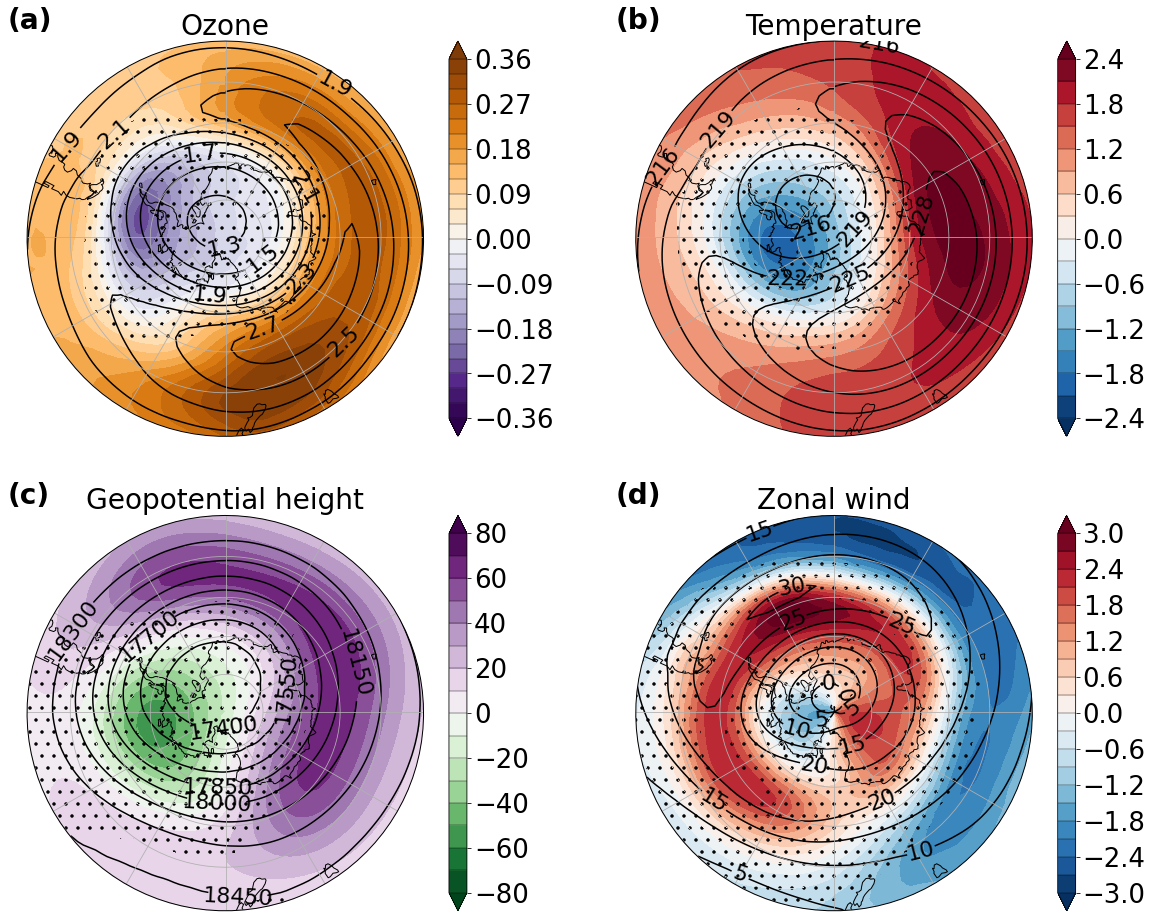

In [23]:
fig = plt.figure(figsize=(20,16))
cont2 = np.arange(1.3,3,0.2)
cont = np.arange(-36, 37, 3)/100
con, ax = plot_map(diff_vmr.sel(lat=slice(-40,-90))[9,:,:], sign_vmr.sel(lat=slice(-40,-90))[9,:,:], \
                   moz_mean_vmr.sel(lat=slice(-40,-90))[9,:,:], cont,  cont2, 'Ozone', 1)
plt.text(-0.05,1.03, '(a)', fontsize=28, fontweight='bold', transform=ax.transAxes)

#plt.text(0.8, 0, '$10^{-2}$ x',  transform=ax.transAxes, fontsize=26)

ticks = np.arange(-36, 37, 6)
c = plt.colorbar(con, ax=ax, drawedges=True)
c.ax.tick_params(labelsize=26)

cont2 = np.arange(198,230,3)
cont = np.arange(-2.4, 2.5, 0.3)
con, ax = plot_map2(diff_t.sel(lat=slice(-40,-90))[10,:,:], sign_t.sel(lat=slice(-40,-90))[10,:,:], moz_mean_t.sel(lat=slice(-40,-90))[10,:,:], \
                   cont,  cont2, 'Temperature', 2)
plt.text(-0.05,1.03, '(b)', fontsize=28, fontweight='bold', transform=ax.transAxes)


ticks = np.arange(-36, 37, 6)
c = plt.colorbar(con, ax=ax,drawedges=True)
c.ax.tick_params(labelsize=26)

cont2 = np.arange(-50, 51, 5)
cont = np.arange(-3, 3.1, 0.3)
con, ax = plot_map2(diff_u.sel(lat=slice(-40,-90))[10,:,:], sign_u.sel(lat=slice(-40,-90))[10,:,:], moz_mean_u.sel(lat=slice(-40,-90))[10,:,:], \
                   cont,  cont2, 'Zonal wind',4)
plt.text(-0.05,1.03, '(d)', fontsize=28, fontweight='bold', transform=ax.transAxes)


ticks = np.arange(-3, 3.1, 0.6)
c = plt.colorbar(con, ax=ax, ticks= ticks, drawedges=True)
c.ax.tick_params(labelsize=26)

cont2 = np.arange(-80, 81, 10)
cont = np.arange(-80, 81, 10)
con, ax = plot_map3(diff_geopoth.sel(lat=slice(-40,-90))[10,:,:], sign_geopoth.sel(lat=slice(-40,-90))[10,:,:], moz_mean_geopoth.sel(lat=slice(-40,-90))[10,:,:], \
                   cont,  10, 'Geopotential height',3)
plt.text(-0.05,1.03, '(c)', fontsize=28, fontweight='bold', transform=ax.transAxes)


ticks = np.arange(-3, 3.1, 0.6)
c = plt.colorbar(con, ax=ax,  drawedges=True)
c.ax.tick_params(labelsize=26)